In [ ]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
img = cv2.imread('./assets/debruyne/10061.jpg')
img.shape

(390, 300, 3)

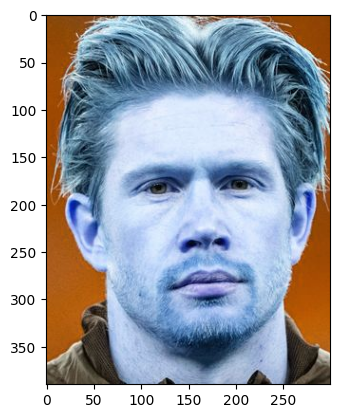

In [ ]:
plt.imshow(img)

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(390, 300)

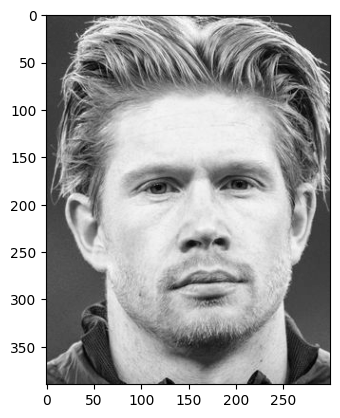

In [ ]:
plt.imshow(gray, cmap='gray')

In [ ]:
face_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[ 46,  92, 231, 231]], dtype=int32)

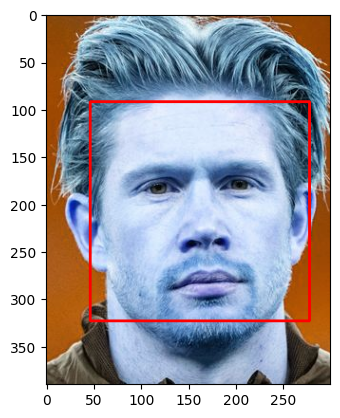

In [ ]:
(x,y,w,h) = faces[0]
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

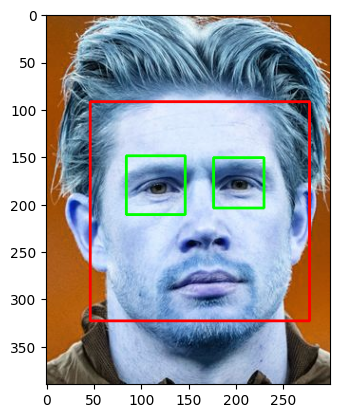

In [ ]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)


plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

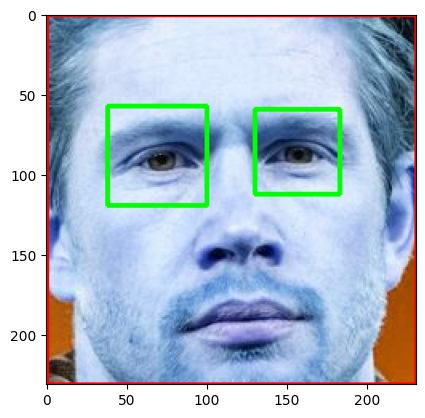

In [ ]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [ ]:
# The actual Function that detects Face and eyes, keep if found, return none if not

def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color
        else: return None

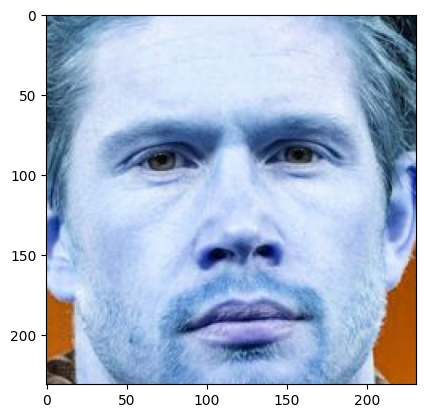

In [ ]:
cropped_image = get_cropped_image_if_2_eyes('./assets/debruyne/10061.jpg')
plt.imshow(cropped_image)

<br><br>

## **MAIN DATA REFINING FUNCTION THAT CURATES USABLE FACES**

<br><br>

In [ ]:
raw_data = "./assets/"
refined_data = "./cropped/"

In [ ]:
img_dirs = []
for entry in os.scandir(raw_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
img_dirs

['./assets/bernardo',
 './assets/debruyne',
 './assets/foden',
 './assets/haaland',
 './assets/rodri']

In [ ]:
for img_dir in img_dirs:
    count = 1
    footballer_name = img_dir.split('/')[-1]
    print(footballer_name)

    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = refined_data + footballer_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)

            cropped_file_name = footballer_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name

            cv2.imwrite(cropped_file_path, roi_color)
            count += 1

bernardo
Generating cropped images in folder:  ./cropped/bernardo
debruyne
Generating cropped images in folder:  ./cropped/debruyne
foden
Generating cropped images in folder:  ./cropped/foden
haaland
Generating cropped images in folder:  ./cropped/haaland
rodri
Generating cropped images in folder:  ./cropped/rodri


<br> **FEATURE ENGINEERING** <br><br>

In [ ]:
import numpy as np
import pywt

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)
    imArray /= 255;
    # compute coefficients
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)
    coeffs_H[0] *= 0;

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

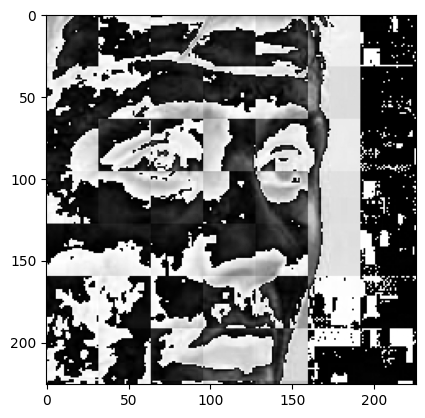

In [ ]:
cropped_img = np.array(roi_color)
plt.imshow(cropped_img)
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

<br> **Making X and Y datasets** <br><br>

In [ ]:
footballer_file_names_dict = {}
for img_dir in cropped_image_dirs:
    footballer_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    footballer_file_names_dict[footballer_name] = file_list

In [ ]:
class_dict = {}
count = 0
for footballer_name in footballer_file_names_dict.keys():
    class_dict[footballer_name] = count
    count = count + 1
class_dict

{'bernardo': 0, 'debruyne': 1, 'foden': 2, 'haaland': 3, 'rodri': 4}

In [ ]:
X, y = [], []
for footballer_name, training_files in footballer_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[footballer_name])

In [ ]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(169, 4096)

In [ ]:
import pickle
pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()